In [1]:
seed_num = 2022

from numpy.random import seed
seed(seed_num)
from tensorflow.random import set_seed
set_seed(seed_num)
import tensorflow as tf
tf.keras.utils.set_random_seed(seed_num)
tf.config.experimental.enable_op_determinism()

import os
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from IPython.display import clear_output
from time import time
import anndata as ad
import seaborn as sns
import scanpy as sc
import pylab as pl
from scipy import stats

from SC2Spa import SI, PP, Vis, SVA

pd.set_option('display.max_columns', None)
%matplotlib inline

/mnt/win1
/mnt/win1/SC2Spa_Notebook/MouseHippocampus_SSV2


# Load

In [2]:
#Load
adata_ref = ad.read_h5ad('../Dataset/AdataMH1.h5ad')
adata_query = ad.read_h5ad('../Dataset/AMB_HC.h5ad')

adata_ref.var_names = adata_ref.var_names.str.upper()
adata_query.var_names = adata_query.var_names.str.upper()

adata_ref.var_names_make_unique()
adata_query.var_names_make_unique()

#Normalize
sc.pp.normalize_total(adata_ref, target_sum=1e4)
sc.pp.normalize_total(adata_query, target_sum=1e4)

#X_ref, X_query, Y_ref = SI.PP_Mapping(adata_ref, adata_query, x_name = 'xcoord', y_name = 'ycoord')

sc.pp.log1p(adata_ref)

Anno = pd.read_csv('ssHippo_RCTD.csv', index_col = 0)
Anno['MCT'] = 't'
index1 = Anno.index[(Anno['celltype_1'] == Anno['celltype_2'])]
Anno['MCT'][index1] = Anno['celltype_1'][index1]
index2 = Anno.index[(Anno['celltype_1'] != Anno['celltype_2'])]
Anno['MCT'][index2] = (Anno['celltype_1'][index2] + '_' + Anno['celltype_2'][index2]).apply(lambda x: '_'.join(sorted(set(x.split('_')))))

adata_ref.obs = adata_ref.obs.merge(Anno, left_index = True, right_index = True, how = 'left')
adata_ref.obsm['spatial'] = adata_ref.obs[['xcoord', 'ycoord']].values

sc.pp.log1p(adata_query)

adata_query.obs['common_name'] = adata_query.obs['common_name'].str.replace('?', '')
adata_query.obs['simp_name'] = adata_query.obs['common_name'].str.split('.',
                        expand = True)[0].str.split(',', expand = True)[0].str.split(' \(',
                                    expand = True)[0].str.replace('cortexm', 'cortex').replace('Medial entorrhinal cortex', 'Medial entorhinal cortex')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/tmp/ipykernel_29485/151545727.py:31: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  adata_query.obs['common_name'] = adata_query.obs['common_name'].str.replace('?', '')


# FineMapping

In [10]:
'''
sta = time()
JGs, WDs = SI.WassersteinD(adata_ref, adata_query, sparse = True,
                           WD_cutoff = 0.1, root = 'WDs/', save = 'WDs_T2')

end = time()
print((end - sta) / 60.0, 'min')
'''

106.58578276236852 min


In [3]:
WD_cutoff = 0.4

root = 'WDs/'
save = 'WDs_T2'

WDs = pd.read_csv(root + save + '.csv')
JGs = sorted(WDs[WDs['Wasserstein_Distance'] < WD_cutoff]['Gene'].tolist())

'''
#adata_ref = adata_ref[:, JGs]
#adata_query = adata_query[:, JGs]

seed(seed_num)
set_seed(seed_num)
tf.keras.utils.set_random_seed(seed_num)

sta = time()

neighbors, dis = SI.FineMapping(adata_ref, adata_query, sparse =True, JGs = JGs, 
                                model_path = None, root = 'Model_SI/',
                                name = 'SI_T2_WD', l1_reg = 1e-5, l2_reg = 0, dropout = 0.05, epoch = 500,
                                batch_size = 4096, nodes = [4096, 1024, 256, 64, 16, 4], lrr_patience = 20,
                                ES_patience = 50, min_lr = 1e-5, save = True, polar = True,
                                n_neighbors = 1000, dis_cutoff = 20, seed = seed_num)

end = time()
print((end - sta) / 60.0, 'min')
'''

n of Referece Genes: 20527
n of Target Genes: 24509
n of Selected Genes: 19577
(35349, 19577)
(127165, 19577)


2022-10-25 18:14:19.329453: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-10-25 18:14:19.329551: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: linbuliao-ThinkStation-P720
2022-10-25 18:14:19.329571: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: linbuliao-ThinkStation-P720
2022-10-25 18:14:19.329816: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.85.2
2022-10-25 18:14:19.329878: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.5
2022-10-25 18:14:19.329895: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 510.73.5 does not match DSO version 510.85.2 -- cannot find working devices in this configuration
2022-10-25 18:14:19.330588: I tensorflow/core/platform/cpu

Epoch 1/500
8/8 [==============================] - 37s 4s/step - loss: 6.2201 - rmse: 0.2030 - lr: 0.0010
Epoch 2/500
8/8 [==============================] - 34s 4s/step - loss: 4.3582 - rmse: 0.1486 - lr: 0.0010
Epoch 3/500
8/8 [==============================] - 34s 4s/step - loss: 3.0904 - rmse: 0.1307 - lr: 0.0010
Epoch 4/500
8/8 [==============================] - 34s 4s/step - loss: 2.2165 - rmse: 0.1183 - lr: 0.0010
Epoch 5/500
8/8 [==============================] - 33s 4s/step - loss: 1.6233 - rmse: 0.1138 - lr: 0.0010
Epoch 6/500
1/8 [==>...........................] - ETA: 29s - loss: 1.3813 - rmse: 0.1096

KeyboardInterrupt: 

In [ ]:
'''
seed(seed_num)
set_seed(seed_num)
tf.keras.utils.set_random_seed(seed_num)

sta = time()

SI.FineMapping(adata_ref, adata_query, sparse =True, model_path = None, root = 'Model_SI/',
               name = 'SI_T2', l1_reg = 1e-5, l2_reg = 0, dropout = 0.05,
               epoch = 500, batch_size = 4096, nodes = [4096, 1024, 256, 64, 16, 4],
               lrr_patience = 20, ES_patience = 50, min_lr = 1e-5, save = True, polar = True,
               n_neighbors = 1000, dis_cutoff = 20, seed = seed_num)

end = time()
print((end - sta) / 60.0, 'min')
'''

neighbors, dis = SI.FineMapping(adata_ref, adata_query, JGs = JGs, sparse =True, model_path = 'Model_SI/SI_T2_WD.h5',
                                polar = True, n_neighbors = 1000, dis_cutoff = 5)

## Visualize Cell Type Locations

In [ ]:
for CT in adata_query.obs['simp_name'].unique():
    
    print('*'*16)
    print(CT)
    print('*'*16)
    print('Transfer:')
    
    Vis.DrawCT1(adata_query, coords_name = 'spatial_mapping',
                CT = CT, c_name = 'simp_name',
                root = 'Transfer2/FM_Valid2/', save = None)

In [ ]:
for CT in adata_query.obs['simp_name'].unique():
    print('*'*16)
    print(CT)
    print('*'*16)
    print('Transfer:')
    Vis.DrawCT1(adata_query, coords_name = 'spatial_mapping',
                CT = CT, c_name = 'simp_name',
                root = 'Transfer2/FM_Valid2/', save = 'SC2HC1')

In [ ]:
for CT in adata_ref.obs['celltype_1'].unique():
    print('*'*16)
    print(CT)
    print('*'*16)
    print('Transfer:')
    Vis.DrawCT1(adata_ref, coords_name = 'spatial',
                CT = CT, FM = True, c_name = 'SSV2',
                root = 'Transfer2/FM_Valid2/', save = 'HC1')

# NRD

In [ ]:
from matplotlib import rc
rc('font', **{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['font.size'] = 16

cmap = sns.cubehelix_palette(n_colors = 32,start = 2, rot=1.5, as_cmap = True)

a = np.array([[0,1]])
pl.figure(figsize=(9, 1.5))
img = pl.imshow(a, cmap=cmap)
pl.gca().set_visible(False)
cax = pl.axes([0, 0, 0.02, 1.6])
pl.colorbar(orientation="vertical", cax=cax)
pl.savefig("Transfer2/colorbar.png", bbox_inches='tight')

## CT

In [4]:
sta = time()

SI.NRD_CT(neighbors, dis, adata_ref, adata_query,
          ct_name = 'simp_name', dis_min = 0.1, exclude_CTs = ['nan'])

end = time()
print((end - sta) / 60, 'min(s)')

0.04182236989339193 min(s)


In [ ]:
cmap = sns.cubehelix_palette(n_colors = 32,start = 2, rot=1.5, as_cmap = True)

for CT in adata_query.obs['simp_name'].unique():
    if(CT in ['nan']):
        continue
    print(CT)
    Vis.DrawCT2(adata_ref, CT, title = True, NRD = True, colorbar = False, cmap=cmap, s=2, x='xcoord', y='ycoord',
               root='Transfer2/FM_NRD/', save='SC2HC1')

## Impute

In [ ]:
sta = time()

adata_impute = SI.NRD_impute(neighbors, dis, adata_ref, adata_query,
                             ct_name='simp_name', dis_min=0.1, exclude_CTs=['nan'])

end = time()
print((end - sta) / 60, 'min(s)')

# SVA

In [ ]:
JGs = sorted(list(set(adata_ref.var_names).intersection(set(adata_query.var_names))))
adata = adata_ref[:, JGs]

model = SI.Self_Mapping(adata, sparse = True, model_path = 'Model_SI/SI_T2.h5')

SVA.PrioritizeLPG(adata, Model = model, percent = 0.5, scale_factor = 1e3,
                  Norm = True)

In [ ]:
adata.var.sort_values('imp_sumup_norm', ascending = False).head()

# Pearson's r

In [ ]:
cmap = sns.cubehelix_palette(n_colors = 32,start = 2, rot=1.5, as_cmap = True)

def VizCus(df, x_name, x_label, y_name, y_label, c_name = None,
           fontsize = 28, vmin= -0.05, vmax = 0.5, s = 14, save = None):
    
    plt.rcParams['font.size'] = fontsize
    plt.figure(figsize = (12, 8))
    if(c_name == None):
        plt.scatter(df[x_name], df[y_name], s = s)
    elif(vmin!=None):
        plt.scatter(df[x_name], df[y_name], s = s, alpha = 0.7,
                c = df[c_name], vmin = vmin, vmax = vmax, cmap = cmap)
    else:
        plt.scatter(df[x_name], df[y_name], s = s, alpha = 0.7,
                c = df[c_name], cmap = cmap)
    plt.colorbar()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    if(save != None):
        plt.savefig('Transfer2/' + save + '.png',
                    dpi = 128, bbox_inches='tight')

In [ ]:
JCs = sorted(list(set(adata_ref.obs_names).intersection(set(adata_impute.obs_names))))

pearson_JGs = pd.DataFrame(np.zeros((len(JGs), 3)), columns = ['gene', 'pearson_r', 'p']) 
pearson_JGs['gene'] = JGs

for i, JG in enumerate(JGs):
    print(i)
    t = stats.pearsonr(adata_impute[JCs, JG].X.flatten(), adata_ref[JCs, JG].X.toarray().flatten())
    pearson_JGs.loc[i, 'pearson_r'] = t[0]
    pearson_JGs.loc[i, 'p'] = t[1]
    clear_output(wait = True)

In [ ]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
adata.var['percent_cell'] = adata.var['n_cells_by_counts'] / adata.shape[0]

t = adata.var[['percent_cell', 'imp_sumup_norm']].reset_index()
t.columns =['gene', 'percent_cell', 'imp_sumup_norm']
pearson_JGs = pearson_JGs.merge(t, how = 'left')

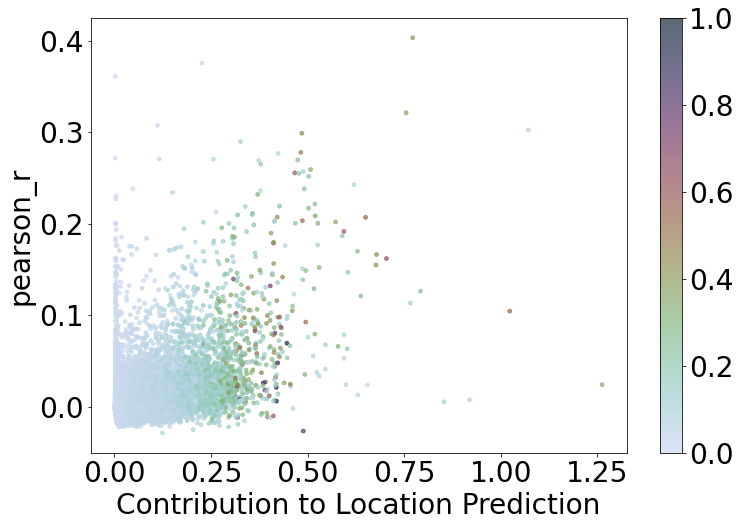

In [27]:
VizCus(pearson_JGs, x_name = 'imp_sumup_norm', x_label = 'Contribution to Location Prediction',
       y_name = 'pearson_r', y_label = 'pearson_r', s = 14, c_name = 'percent_cell',
       vmin = 0, vmax = 1, save = 'Transfer2_imp_r_pcell.png')

In [2]:
#pearson_JGs.sort_values('pearson_r', ascending = False).to_csv('Transfer2/T2_stats.csv', index = None)
pearson_JGs = pd.read_csv('Transfer2/T2_stats.csv')
pearson_JGs.sort_values('pearson_r', ascending = False).head(10)

,gene,pearson_r,p,percent_cell,imp_sumup_norm
0,HPCA,0.403153,0.000000e+00,0.417636,0.772095
1,C1QL2,0.375441,0.000000e+00,0.031627,0.226433
2,6030445D17RIK,0.360912,0.000000e+00,0.000283,0.002228
3,NRGN,0.321082,2.395553e-271,0.377210,0.755274
4,FIBCD1,0.307258,1.685399e-247,0.033579,0.111303
5,TSHZ2,0.302188,4.506501e-239,0.069252,1.071571
6,PPP3CA,0.298777,1.695301e-233,0.451837,0.485366
7,CPNE6,0.289595,7.320895e-219,0.117457,0.326439
8,OLFM1,0.277887,5.583135e-201,0.469150,0.482522
9,HS3ST4,0.276645,3.930274e-199,0.091148,0.423905


In [5]:
select = ~(pearson_JGs['pearson_r'].isna() | pearson_JGs['imp_sumup_norm'].isna())
stats.pearsonr(pearson_JGs['pearson_r'].values[select], pearson_JGs['imp_sumup_norm'].values[select])

(0.4960995361470442, 0.0)

In [4]:
pearson_JGs.shape

(19986, 5)

In [9]:
pearson_JGs

,gene,pearson_r,p,percent_cell,imp_sumup_norm
0,HPCA,0.403153,0.000000e+00,0.417636,0.772095
1,C1QL2,0.375441,0.000000e+00,0.031627,0.226433
2,6030445D17RIK,0.360912,0.000000e+00,0.000283,0.002228
3,NRGN,0.321082,2.395553e-271,0.377210,0.755274
4,FIBCD1,0.307258,1.685399e-247,0.033579,0.111303
...,...,...,...,...,...
19981,WFDC12,NaN,NaN,0.000141,0.002120
19982,WI1-1749A12.1,NaN,NaN,0.000085,0.002082
19983,WNT1,NaN,NaN,0.000085,0.002980
19984,WNT3A,NaN,NaN,0.000085,0.001994


In [8]:
pearson_JGs['pearson_r'].rank(method = 'min')

0        19534.0
1        19533.0
2        19532.0
3        19531.0
4        19530.0
          ...   
19981        NaN
19982        NaN
19983        NaN
19984        NaN
19985        NaN
Name: pearson_r, Length: 19986, dtype: float64

In [10]:
~pearson_JGs['pearson_r'].isna()

0         True
1         True
2         True
3         True
4         True
         ...  
19981    False
19982    False
19983    False
19984    False
19985    False
Name: pearson_r, Length: 19986, dtype: bool

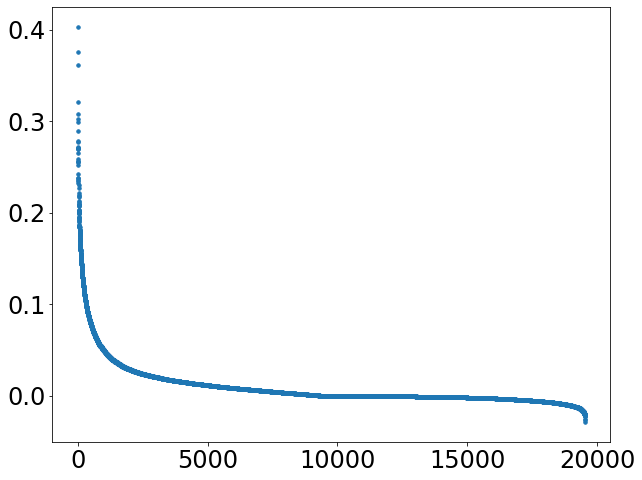

In [22]:
t = pearson_JGs[~pearson_JGs['pearson_r'].isna()]
plt.rcParams['font.size'] = 24
plt.figure(figsize=(10, 8))
plt.scatter(t.index+1, t['pearson_r'], s = 12)
plt.savefig('Transfer2/rankplot.png', bbox_inches='tight')

# Visualize

In [18]:
GLs = pearson_JGs[pearson_JGs['percent_cell']>0.01].sort_values('pearson_r', ascending = False)['gene'][:20]
GLs

0        HPCA
1       C1QL2
3        NRGN
4      FIBCD1
5       TSHZ2
6      PPP3CA
7       CPNE6
8       OLFM1
9      HS3ST4
11      PROX1
12    NEUROD6
13       CHGB
14      NPTXR
15      PTK2B
16       CHN1
17      WIPF3
18     SNAP25
19       SNCA
20     RBFOX1
21       CRYM
Name: gene, dtype: object

In [ ]:
cmap = sns.cubehelix_palette(n_colors = 32,start = 2, rot=1.5, as_cmap = True)

GeneInfo = pd.read_csv('GeneInfo_DS_CTS.csv', index_col = 0)

GLs = pearson_JGs[pearson_JGs['percent_cell']>0.01].sort_values('pearson_r', ascending = False)['gene'][:20]
    
GLs = list(set(GLs))
s = 4

for gene in GLs:
    print('*'*32)
    print(gene)
    print('*'*32)
    print('scRNAseq:')
    Vis.DrawGenes2(adata_query, gene = gene, lim = False, 
                   xlim = [650, 5750], ylim = [650, 5750], cmap = cmap,
                   FM = True, CTL = None, c_name = 'simp_name', root = 'Transfer2/FM_Valid1/',
                   s = s, x_name = 'x_transfer', y_name = 'y_transfer', title = False, save = 'AMB')
    print('ST:')
    Vis.DrawGenes2(adata_ref, gene = gene, lim = True,
                   xlim = [650, 5750], ylim = [650, 5750], cmap = cmap,
                   FM = True, CTL = None, c_name = 'SSV2', root = 'Transfer2/FM_Valid1/', 
                   s = s, x_name = 'xcoord', y_name = 'ycoord', title = False, save = 'HC1')
    print('Imputed ST:')
    Vis.DrawGenes2(adata_impute, gene = gene, lim = True,
                   xlim = [650, 5750], ylim = [650, 5750], cmap = cmap,
                   FM = True, CTL = None, c_name = 'SSV2', root = 'Transfer2/FM_Valid1/', 
                   s = s, x_name = 'xcoord', y_name = 'ycoord', title = False, save = 'HC1_Impute')

## Extend Gene Throughput

In [49]:
sc.pp.highly_variable_genes(adata_ref, n_top_genes=8000)
sc.pp.highly_variable_genes(adata_query, n_top_genes=8000)

GeneSet1 = set(adata_query.var_names) - set(adata_ref.var_names)
min_mean = 0.05
var_selected = adata_query.var.loc[GeneSet1].sort_values('dispersions', ascending = False)
var_selected = var_selected[var_selected['means']>min_mean]
genes_extended = var_selected.index.tolist()
var_selected.head(20)

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
LCN2,256,False,256,0.016618,99.806102,2194.0,True,0.050787,4.334955,4.518140
MIR692-1,1093,False,1093,0.008438,99.172145,1114.0,True,0.053390,2.612002,0.628484
RP23-102H7.9,26767,False,26767,0.328294,79.726270,43344.0,False,0.928229,2.580593,0.253295
0610009B22RIK,11744,False,11744,0.108174,91.104917,14282.0,False,0.391227,2.460440,0.114188
RPL10-PS3,2318,False,2318,0.018178,98.244312,2400.0,False,0.089304,2.442805,0.246511
GM27441,1405,False,1405,0.010967,98.935832,1448.0,False,0.053208,2.437805,0.235225
GM23935,5401,False,5401,0.044377,95.909201,5859.0,False,0.201273,2.401343,0.152910
AMD2,1957,False,1957,0.015232,98.517739,2011.0,False,0.066279,2.395576,0.139890
0610007P14RIK,15875,False,15875,0.148824,87.976035,19649.0,False,0.507857,2.393987,-0.204973


In [ ]:
cmap = sns.cubehelix_palette(n_colors = 32,start = 2, rot=1.5, as_cmap = True)

for gene in genes_extended:
    print('*'*32)
    print(gene)
    print('*'*32)
    print('scRNAseq:')
    Vis.DrawGenes2(adata_query, gene = gene, colorbar = False, lim = False, 
                   xlim = [650, 5750], ylim = [650, 5750], cmap = cmap,
                   FM = True, CTL = None, c_name = 'simp_name', root = 'Transfer2/FM_Valid3/',
                   s = 2, x_name = 'x_transfer', y_name = 'y_transfer', title = False, save = 'AMB')
    Vis.DrawGenes2(adata_impute, gene = gene, colorbar = False, lim = True,
                   xlim = [650, 5750], ylim = [650, 5750], cmap = cmap,
                   FM = True, CTL = None, c_name = 'SSV2', root = 'Transfer2/FM_Valid3/', 
                   s = 2, x_name = 'xcoord', y_name = 'ycoord', title = False, save = 'HC1_Impute')

## Correct low-quality data

In [51]:
sc.pp.highly_variable_genes(adata_ref, n_top_genes=8000)
sc.pp.highly_variable_genes(adata_query, n_top_genes=8000)

In [60]:
GeneSet1 = set(adata_query.var_names).intersection(adata_ref.var_names)
min_mean = 2
var_selected = adata_query.var.loc[GeneSet1].sort_values('dispersions', ascending = False)
var_selected = var_selected[var_selected['means']>min_mean]

select1 = adata_ref.var.loc[var_selected.index, 'dispersions'] < var_selected.loc[:, 'dispersions']
select2 = adata_ref.var.loc[var_selected.index, 'means'] < var_selected.loc[:, 'means']

var_selected = var_selected[select1 & select2]

genes_corrected = var_selected.index[:10].tolist()
var_selected.head(20)

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
CST3,79493,False,79493,9.679288,39.790802,1277937.0,True,4.329032,5.880498,0.707107
APOE,60049,False,60049,7.377496,54.517981,974036.0,True,3.972071,5.479296,0.335551
MT1,60668,False,60668,4.345601,54.049141,573741.0,True,3.399347,5.037225,1.690713
BSG,54309,False,54309,1.382586,58.865544,182540.0,True,2.295201,4.741158,3.536367
SLC1A2,68726,False,68726,4.239374,47.945890,559716.0,True,3.314414,4.738564,1.242480
ATP1A2,39645,False,39645,2.457176,69.972279,324416.0,True,3.080835,4.726773,1.680076
CLU,49127,False,49127,2.777411,62.790469,366696.0,True,3.052915,4.627334,1.542981
MEG3,81423,False,81423,7.414965,38.328991,978983.0,True,3.411417,4.497843,0.881205
MT2,32600,False,32600,1.629927,75.308268,215196.0,True,2.479486,4.394508,2.036330
PTN,55037,False,55037,2.059805,58.314145,271952.0,True,2.808583,4.299278,0.809043


In [63]:
adata_ref.var.loc[['SLC1A2']]

,n_cells,mt,ERCC,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
SLC1A2,20861,False,False,20861,1.118402,47.469279,44414.0,True,2.960641,3.960118,0.909987


In [ ]:
cmap = sns.cubehelix_palette(n_colors = 32,start = 2, rot=1.5, as_cmap = True)

for gene in genes_corrected:
    print('*'*32)
    print(gene)
    print('*'*32)
    print('ST:')
    Vis.DrawGenes2(adata_ref, gene = gene, colorbar = False, lim = True,
                   xlim = [650, 5750], ylim = [650, 5750], cmap = cmap,
                   FM = True, CTL = None, c_name = 'SSV2', root = 'Transfer2/FM_Valid4/', 
                   s = 2, x_name = 'xcoord', y_name = 'ycoord', title = False, save = 'HC1')
    print('scRNAseq:')
    Vis.DrawGenes2(adata_query, gene = gene, colorbar = False, lim = False, 
                   xlim = [650, 5750], ylim = [650, 5750], cmap = cmap,
                   FM = True, CTL = None, c_name = 'simp_name', root = 'Transfer2/FM_Valid4/',
                   s = 2, x_name = 'x_transfer', y_name = 'y_transfer', title = False, save = 'AMB')
    print('Imputed ST:')
    Vis.DrawGenes2(adata_impute, gene = gene, colorbar = False, lim = True,
                   xlim = [650, 5750], ylim = [650, 5750], cmap = cmap,
                   FM = True, CTL = None, c_name = 'SSV2', root = 'Transfer2/FM_Valid4/', 
                   s = 2, x_name = 'xcoord', y_name = 'ycoord', title = False, save = 'HC1_Impute')